## Chapter 15: Recurrent networks 

# 15.2  Dynamic Systems *without* memory

In this Section we introduce the concept of *recurrent networks*, which are the natural extension of what we have discussed thus far for dealing with *ordered data*.  

In [18]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import recurrent_library as recurlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer
from datetime import datetime 
import copy
import matplotlib.pyplot as plt
from matplotlib import gridspec

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 15.2.1  The simplest dynamic system

When we saw that a set of input data points $x_1,\,x_2,...,x_P$ is *ordered*, what do we mean?  Well in plain English we just mean that the point $x_1$ comes before $x_2$, the point $x_2$ comes before $x_3$, and so on.  The simplest way to say this in the language of math is to say that the point $x_2$ follows the point $x_1$ by being passed through (or 'plugged into') a function $f\left(\cdot\right)$ as

\begin{equation}
x_{2} = f\left(x_{1}\right).
\end{equation}

Likewise  $x_3$ follows $x_2$ by being passed through the function function $f$ likewise as

\begin{equation}
x_{3} = f\left(x_{2}\right).
\end{equation}

And likewise, in general we can say that the point $x_p$ follows the point $x_{p-1}$ mathematically as

\begin{equation}
x_{p} = f\left(x_{p-1}\right) 
\end{equation}

for p = 2,...,P.

Here we have translated 'order' to mean that each and every point is dependent only on its direct predecessor, all via a single function $f$ (which could be a traditional mathematical, or computational function).  This is the simplest translation - mathematically speaking - of the notion that our points $x_1$ through $x_P$ are ordered, but it is by no means the only translation.  

Nonetheless this simple description is one of the most common ways of modeling ordered data used today, and it goes by a large number of names (as variants of it are studied in virtually every area of science / engineering / mathematics) - including the names *discrete dynamic system*, a *discrete dynamical system*, a *recurrence relation*, a *difference equation*, a *complex system*, and the list goes on...  In the context of machine learning - for reasons we will detail below - we will refer to this as a *dyamic system without memory* or at times just a *dynamic system* for short. 

Lets take a look at a few famous examples of this simple dynamic system.

#### <span style="color:#a50e3e;">Example 1. </span>  Exponential growth modeling

A sequence of inputs $x_1,...,x_P$ grows *linearly* if it obeys the simple dynamic system below

\begin{equation}
\begin{array}
\
x_1 = \gamma \\
x_{p} = w_0 + w_1x_{p-1}   
\end{array}
\end{equation}

where $\gamma$, $w_0$, and $w_1$ are constants.  Here the function $f$ is *linear*, and given by $f\left(x\right) = w_0 + w_1x$.  With dynamical systems the value assigned to $x_1 = \gamma$ is referred to as the *initial condition*, and its setting can significantly change the trajectory of a sequence generated by such a system (as can the parameters of the update formula).  

Below we show two example sequences of length $P = 10$.  In the first, shown in the left panel below, we set the initial condition $x_1 = 2$ and $w_0 = 0$ and $w_1 = 2$.  Note while each point in the sequence increases *linearly* from step to step, the data overall is increasing exponentially upwards.  In the right panel we use an initial condition of $x_1 = 1$ with $w_0 = -2$ and $w_1 = 2$.  This data - while decreasing linearly at each step - globally is decreasing exponentially.

<IPython.core.display.Javascript object>


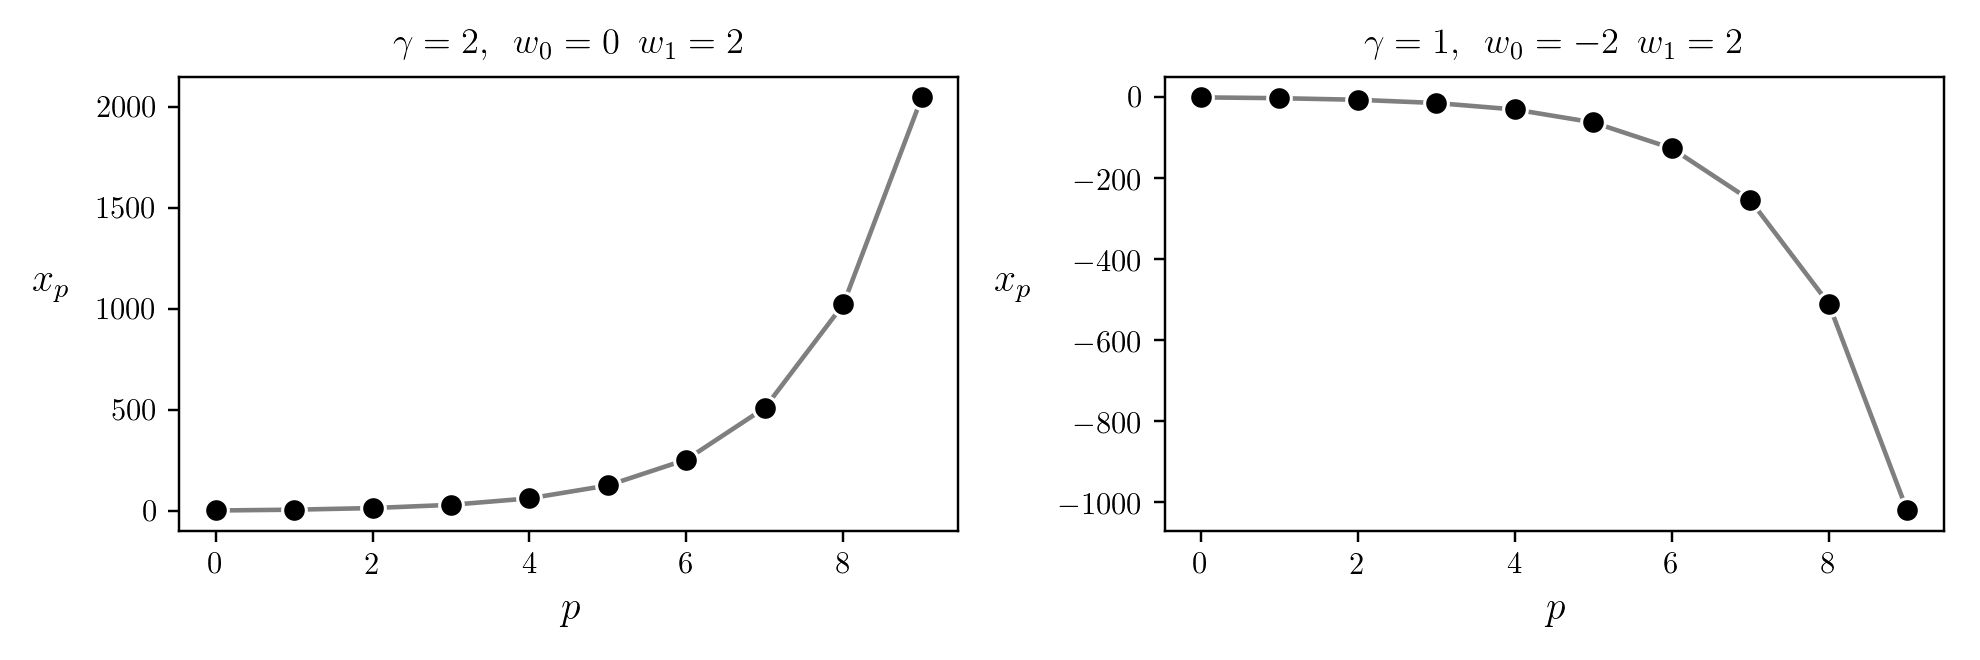

In [69]:
## This code cell will not be shown in the HTML version of this notebook
# function for linear growth
def linear_growth(x):
    return w_0 + w_1*x

# create a logistic sequence via for loop
num_elements = 10              # number of points to generate
sequence1 = []                 # container for generated points
x = 2                          # our initial point
w_0 = 0; w_1 = 2;
for i in range(num_elements):
    x = linear_growth(x)
    sequence1.append(x)
    
sequence2 = []                 # container for generated points
x = 1                          # our initial point
w_0 = -2; w_1 = 2;
for i in range(num_elements):
    x = linear_growth(x)
    sequence2.append(x)
    
### plot the result ###
fig = plt.figure(figsize = (9,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0]);
ax2 = plt.subplot(gs[1]); 

ax1.scatter(np.arange(len(sequence1)),sequence1,c = 'k',edgecolor = 'w',s = 60,linewidth = 1,zorder = 3);
ax2.scatter(np.arange(len(sequence2)),sequence2,c = 'k',edgecolor = 'w',s = 60,linewidth = 1,zorder = 3);
ax1.plot(sequence1,alpha = 0.5,c = 'k');
ax2.plot(sequence2,alpha = 0.5,c = 'k');  # plot lines connecting consecutive points for visualization purposes

# label axes
ax1.set_xlabel(r'$p$',fontsize = 13)
ax1.set_ylabel(r'$x_p$',fontsize = 13,rotation = 0,labelpad = 15)
ax1.set_title(r'$\gamma = 2,\,\,\,w_0 = 0\,\,\,w_1 = 2$')
ax2.set_xlabel(r'$p$',fontsize = 13)
ax2.set_ylabel(r'$x_p$',fontsize = 13,rotation = 0,labelpad = 15)
ax2.set_title(r'$\gamma = 1,\,\,\,w_0 = -2\,\,\,w_1 = 2$')

This kind of dynamic system is precisely what we use when calculating *compound interest* on a loan.  For example, the run shown in the left panel above (could be interpreted (if we suppose $p$ has a unit of weeks and $x_p$ dollars) as showing the total amount owed on a loan of $x_1 = \$2$ at an interest rate of $100\%$ ($w_1 = 2$) per week over the period of $10$  weeks.  This kind of ridiculous high interest loan is often made by 'loansharks' in the movies, and by predatory 'payday loan' shops in the real world.

More generally the formula for compound interest (when none of the principal or interest is repaid at each period) on an initial loan of $x_1$ dollars is a version of the linear growth model above

\begin{equation}
x_p = \left(1 + \text{interest rate}\right)x_{p-1}.
\end{equation}

In other words, it is the exponential growth model with $w_0 = 0$ and $w_1 = \left(1 + \text{interest rate}\right)$.

This sort of model is also used as a simple model for uncapped *population growth*.  For example, suppose a single species of creature (bacteria, bunny rabbits, humans, whatever) live alone on a planet that has an infinite amount of space, resources, etc.,  Suppose at the start of the universe there are $2$ creatures, and after each period of time (e.g., a day) they reproduce at a rate of $100\%$.  Since there are infinite resources in this universe they can go on reproducing forever, reproducing at an exponential rate.  This scenario can also be interpreted as the example in the left panel above (where $x_1 = 2$ denotes the initial number of creatures and $w_1 = 2$ the growth rate).  

Just like compound interest, the uncapped population growth model falls into the same kind of framework as we saw above as

\begin{equation}
x_p = \left(\text{growth rate per period}\right)x_{p-1}.
\end{equation}

In other words, it is the exponential growth model with $w_0 = 0$ and $w_1 = \left(1 + \text{growth rate per period}\right)$.

#### <span style="color:#a50e3e;">Example 2. </span>  Logistic growth and chaotic systems

In this example we illustrate several examples of input data generated via the classical *logistic system*, defined as follows

\begin{equation}
\begin{array}
\
x_1 = \gamma \\
x_{p} = w x_{p-1}\left(1 - x_{p-1} \right).
\end{array}
\end{equation}

In other words, this is a dynamic system with update function  $f\left(x\right) = wx\left(1 - x\right)$.

It is called a *logistic system* because (like *logistic functions themselves*) it arises in the modeling of population growth under the assumption that resources in an enviroment are limited.  The modeling idea is basically this: if $x_p$ denotes the population of a single species of creature (e.g., bacterium, bunny rabbits, humans, whatever) in a closed system with a maximum amount of space / resources the growth rate of a population cannot follow the exponential rate detailed in the previous example forever.  In the beginning, when there are not too many of the creatures, the growth can indeed be expontial - thus the first part of the equation above $wx_{p-1}$ (the exponential growth we saw previously).  But at a certain point, when space and resources become limited, competition for survival causes the growth rate to slow down.  Here this concept is modeled by the second portion of the equation above: $\left(1 - x_{p-1}\right)$.  Here $1$ denotes the maximum population permitted by the limited resources of the enviorment (this could be set to some other number, but for simplicity we have left it at $1$).  As the population $x_p$ approaches this maximum level this second term tempers the exponential growth pursued by the first term, and the population levels off.  

For the right settings we can generate our familiar logistic 's' shape curve - as shown below for $P = 30$ points using an initialization of $x_1 = 10^{-4}$ and $w = 1.75$.

<IPython.core.display.Javascript object>


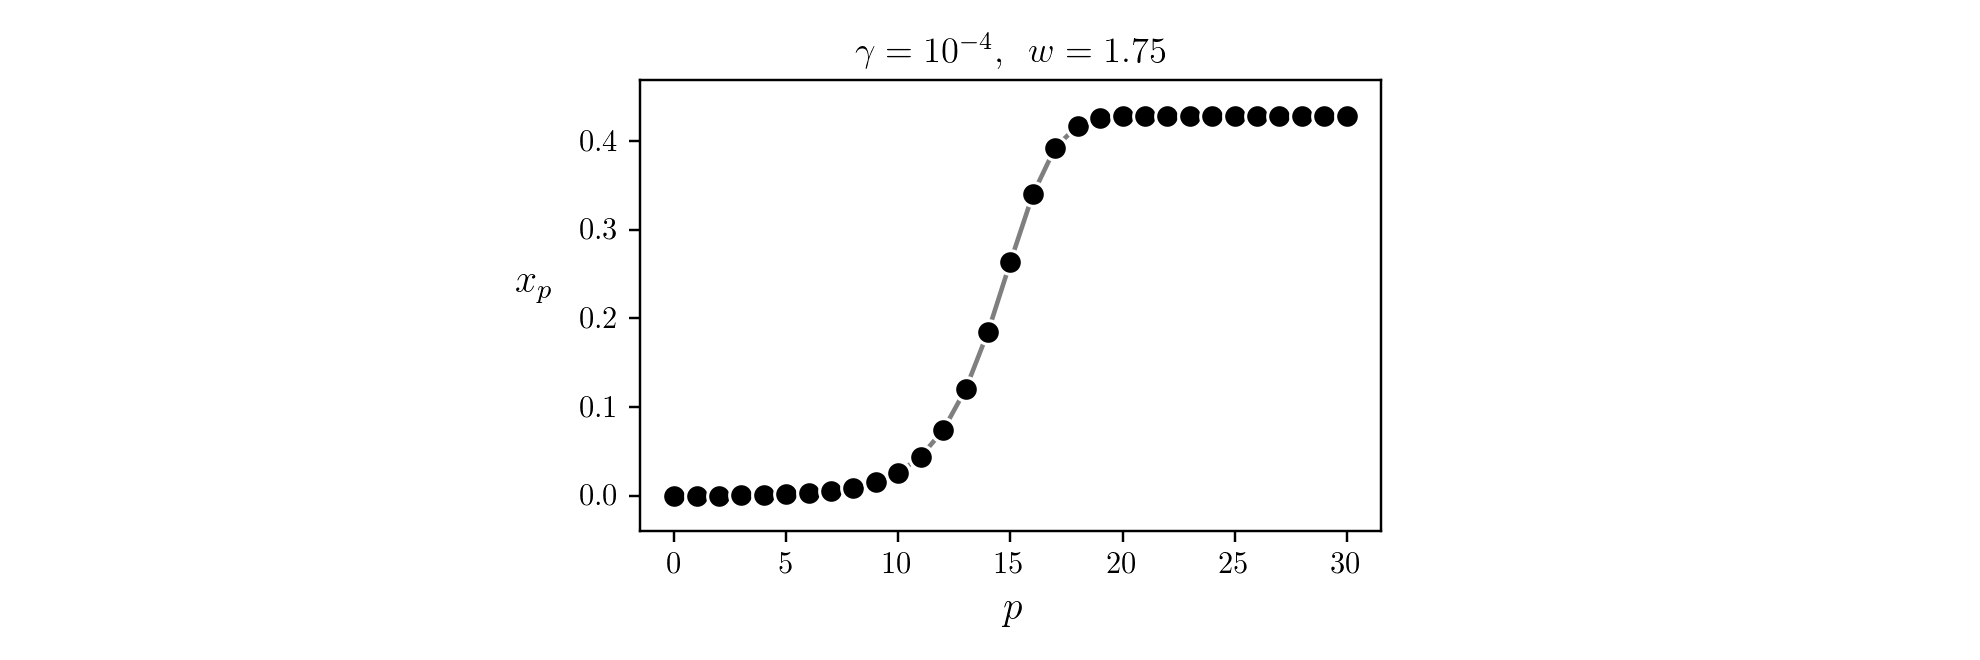

In [91]:
## This code cell will not be shown in the HTML version of this notebook
# logistic function
def logistic(x,w):
    return w*x - w*x**2

# we could use a for loop, but lets define 
# the logistic system programmatically
def f(x,w,n,seq):  # x = input point, n = desired number of compositions
    seq.append(x)
    if n > 1:
        return f(w*x - w*x**2,w,n-1,seq)
    else:
        seq.append(w*x - w*x**2)
        return seq
    
# create the same sequences using our recursive definition of the logistic system
sequence1 = f(0.0001,1.75,30,[]); 

# plot the result
fig = plt.figure(figsize = (9,3))
gs = gridspec.GridSpec(1, 3, width_ratios=[1,2,1]) 
ax = plt.subplot(gs[0]); ax.axis('off')
ax1 = plt.subplot(gs[1]); 
ax2 = plt.subplot(gs[2]); ax2.axis('off')

ax1.scatter(np.arange(len(sequence1)),sequence1,c = 'k',edgecolor = 'w',s = 60,linewidth = 1,zorder = 3);
ax1.plot(sequence1,alpha = 0.5,c = 'k');

# label axes
ax1.set_xlabel(r'$p$',fontsize = 13)
ax1.set_ylabel(r'$x_p$',fontsize = 13,rotation = 0,labelpad = 15)
ax1.set_title(r'$\gamma = 10^{-4},\,\,\,w = 1.75$')

This dynamic system is often *chaotic* (being a prime exemplar in *chaos theory*) because slight adjustments to the initial condition and weight $w$ can produce drastically different sequences of data.  For example, below we show two sequences of length $P = 70$ generated via the system above.  In the left panel we have set the initial condition $\gamma = 10^{-4}$ and $w = 3$, and in the right we use the same initial condition and $w = 4$.  As you can see the form taken by the two resulting sequences is drastically different.  In the case on the left the resulting sequence converges nicely, while the latter sequence bounces around crazily (and will do so forever).  In fact the sequence on the right is *almost* random, a fact that [can be proven mathematically]([https://www.complexityexplorer.org/courses/22-introduction-to-dynamical-systems-and-chaos-winter-2015]).

<IPython.core.display.Javascript object>


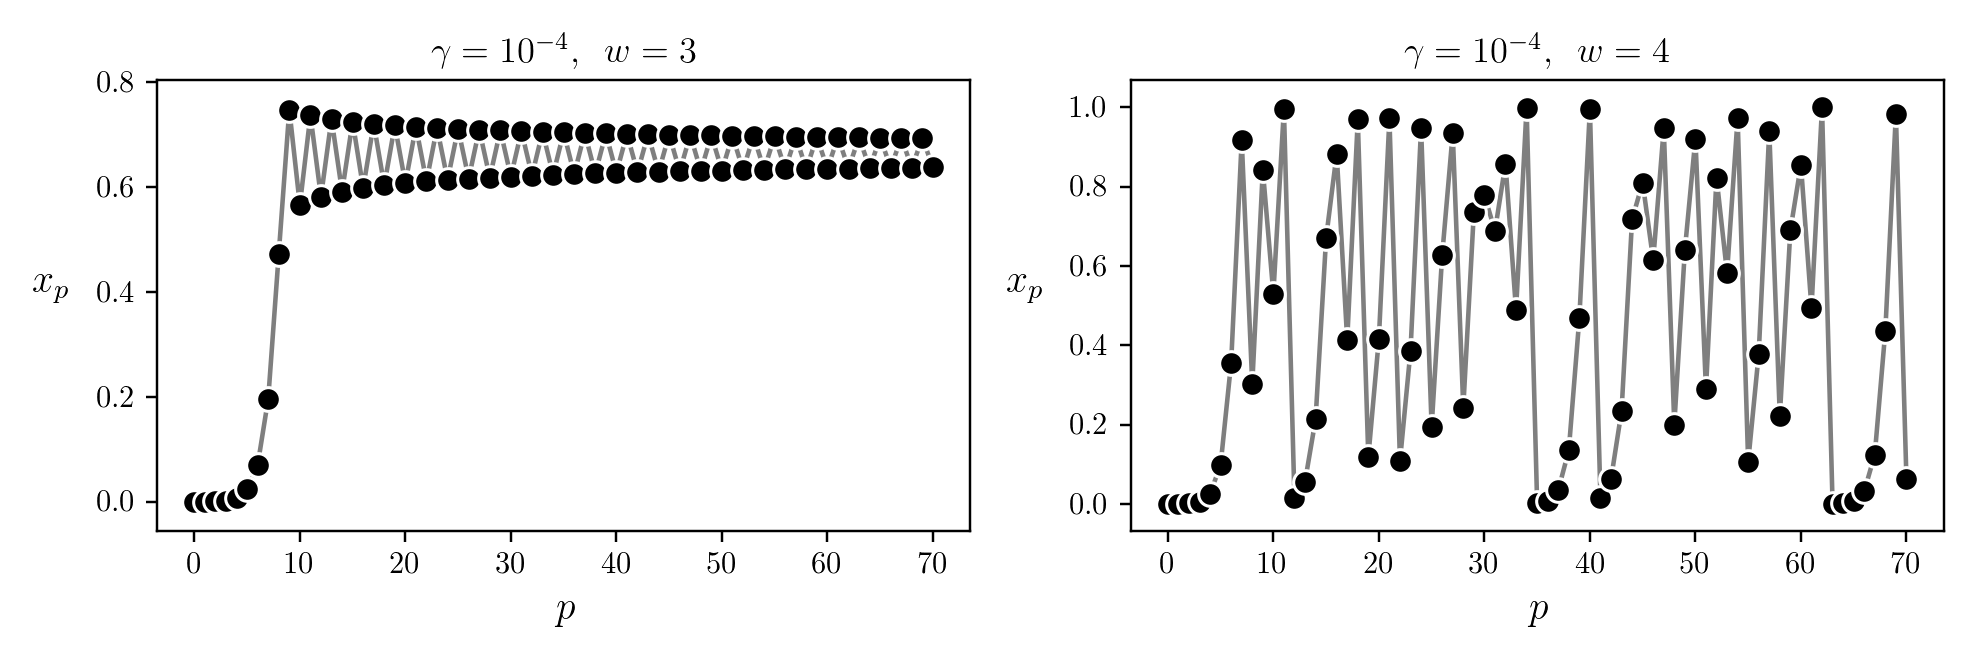

In [92]:
## This code cell will not be shown in the HTML version of this notebook
# create the same sequences using our recursive definition of the logistic system
sequence1 = f(0.0001,3,70,[]); sequence2 = f(0.0001,4,70,[]);

# plot the result
fig = plt.figure(figsize = (9,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1]) 
ax1 = plt.subplot(gs[0]);
ax2 = plt.subplot(gs[1]); 

ax1.scatter(np.arange(len(sequence1)),sequence1,c = 'k',edgecolor = 'w',s = 60,linewidth = 1,zorder = 3);
ax2.scatter(np.arange(len(sequence2)),sequence2,c = 'k',edgecolor = 'w',s = 60,linewidth = 1,zorder = 3);
ax1.plot(sequence1,alpha = 0.5,c = 'k');
ax2.plot(sequence2,alpha = 0.5,c = 'k');  # plot lines connecting consecutive points for visualization purposes

# label axes
ax1.set_xlabel(r'$p$',fontsize = 13)
ax1.set_ylabel(r'$x_p$',fontsize = 13,rotation = 0,labelpad = 15)
ax1.set_title(r'$\gamma = 10^{-4},\,\,\,w = 3$')

ax2.set_xlabel(r'$p$',fontsize = 13)
ax2.set_ylabel(r'$x_p$',fontsize = 13,rotation = 0,labelpad = 15)
ax2.set_title(r'$\gamma = 10^{-4},\,\,\,w = 4$')

## 15.2.3  The order of a dynamic system

In the first Subsection above we translated the notion that the sequence of points $x_1,\,x_2,...,x_P$ is ordered mathematically into 

\begin{equation}
x_{p} = f\left(x_{p-1}\right) 
\end{equation}

i.e., that each point (after the initial condition $x_1$ is based entirely off its direct predecessor.  More generally we can translate the 'ordered' notion to mean that every point is derived from its previous $T \geq 1$ predecessors as

\begin{equation}
x_{p} = f\left(x_{p-1},\,x_{p-2},\,...,x_{p-T}\right)   
\end{equation}

for $p = T,...,P$.  This value $T$ is often called the *order* of a dynamic system.  So for example, the instances detailed in the previous Subsections all have order $1$.  

Notice that a general order $T$ dynamic system must have $T$ initial conditions, since in order to generate the first point $x_T$ all previous values $x_{T-1} = \gamma_{T-1}$ through $x_1 = \gamma_1$ must already be set (or 'initialized').  

#### <span style="color:#a50e3e;">Example 3. </span>  The Fibonachi Sequence

A classic example of a dynamic system of order $T = 2$ is the 

\begin{equation}
\begin{array}
\
x_1 = 0 \\
x_2 = 1 \\
x_{p} = x_{p-1} + x_{p-2}
\end{array}
\end{equation}

This sequence naturally creates a 'golden spiral' like the one shown below ([image credit](https://www.geeksforgeeks.org/program-for-nth-fibonacci-number/)).



<figure>
<p>
<img src= '../../mlrefined_images/recurrent_images/fibonacci_sequence.png' width="40%" height="40%" alt=""/>
</p>
<figcaption> <strong>Figure 1:</strong> <em> 

</em>
</figcaption>
</figure>

## 15.2.4 Every point of a dynamic system without memory is directly related to the initial condition

If we closely analyze the update step for any given dynamic system like the ones above, we can see that *absolutely every point is directly related to the initial condition $x_1$*.  How?  If we know that $x_3$ is related to its predecssor as 

\begin{equation}
x_3 = f\left(x_2\right)
\end{equation}

and $x_2$ is related to the initial condition similarly as

\begin{equation}
x_2 = f\left(x_1\right)
\end{equation}

then plugging in the form of $x_2$ above into the relationship describing $x_3$ we have that

\begin{equation}
x_3 = f\left(x_2\right) = f\left(\,f\left(x_1\right)\right).
\end{equation}

In other words, the third point $x_3$ is precisely the initial condition $x_1$ passed through $f$ twice.

This relationship holds more generally as well.  By the same logic we the $p^{th}$ point $x_p$ is directly related to the initial condition by passing it through the function $p-1$ times as

\begin{equation}
x_p = f\left(\,f\left(\,\cdots f\left(x_1\right)\right)\cdots\right).
\end{equation}

In other words, every point generated by a dynamic system without memory is in fact directly related to the initial condition $x_1$ alone.

## 15.2.4  Why are these dynamic systems 'memoryless'?

## 12.5.5  Stochastic memoryless dynamic systems

#### <span style="color:#a50e3e;">Example 1. </span>  The simple language models

Claude Shannon - language model proposed is simple - words depend recursively / stochastically on the ones which preceed them.  Usually modeled as a 'transition', but what is the real deal here - how can this be modeled algebraically?  There is no addition, right?  

\begin{equation}
\begin{array}
\
x_0 = \alpha \\
x_t = f(x_{t-1})
\end{array}
\end{equation}

where 

\begin{equation}
P\left(x_t \, \vert \, x_{t-1} = \alpha \right)
\end{equation}

What is the deterministic analog of this?  Just a sequence like any function that maps a set of points to itself.

## 15.5.6 Input / output dynamic systems

#### <span style="color:#a50e3e;">Example 1. </span>  The moving average


\begin{equation}
\
y_{p} = \frac{1}{T}\sum_{j=p-T}^p x_j
\end{equation}

#### <span style="color:#a50e3e;">Example 1. </span>  Convolution


\begin{equation}
\
y_{p} = \sum_{j=p-T}^p c_jx_j
\end{equation}